<a href="https://colab.research.google.com/github/IAI-UNSAM/ML_UNSAM/blob/master/15b_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#The stars
import tensorflow as tf
from tensorflow import keras

In [2]:
tf.__version__

'2.2.0'

In [3]:
keras.__version__

'2.3.0-tf'

In [4]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')]

In [5]:
# Una cosita, nomás
tf.keras.backend.set_floatx('float32')

# Generative Adversarial Networks

## Datos (Fashion_MNIST)

Asi como sklearn trae utilidades para cargar datasets estandar, keras también trae. En general, keras puede aceptar datasets en forma de Numpy Arrays (como sklearn), pero también trae una clase Dataset que esta optimizada para cargar datos (incluso si son mas grandes que la memoria RAM del equipo).

In [6]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

4423680/4422102 [==============================] - 0s 0us/step


En Datasets grandes, CrossValidation puede ser muy costoso, por lo cual se recomienda separar un conjunton de validación aparte del training. Esto hacemos a continuación.

También normalizamos los píxeles (que van de 0 a 255) para que estén entre 0 y 1.

In [7]:
#Separo en entrenamiento y validacion, y normalizo los pixeles
# Los paso a 32 bits para que no haya problemas con TF.
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

(60000, 28, 28)


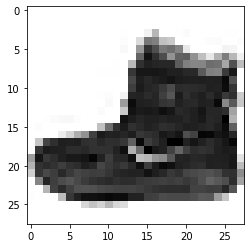

In [8]:
print(X_train_full.shape)

plt.imshow(X_train[0], cmap='binary', interpolation='None')

Los targets son numericos, del 0 al 9. Podemos guardar las etiquetas asi nos es mas facil analizar que tan bien o mal funciona nuestro modelo:

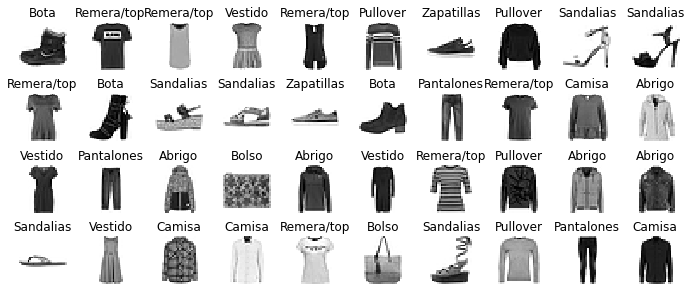

In [9]:
class_names = ["Remera/top", "Pantalones", "Pullover", "Vestido", "Abrigo",
               "Sandalias", "Camisa", "Zapatillas", "Bolso", "Bota"]

n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

In [10]:
# Una función útil
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

## Definir una GAN

Podemos hacerlo usando la API secuencial de `keras`

In [68]:
# Tamaño del encoding
codings_size = 30

# Defino el generador como un decodificador de encoder variacional
generator = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[codings_size]),
    keras.layers.Dense(150, activation="selu"),
    # Usa una sigmoide para mantener los pixels entre 0 y 1.
    # Recuerden que las imágenes de Fashion_MNIST son 28x28
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

# El discriminador es una red tipo MLP para clasificación binaria
discriminator = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    # Dos capas ocultas de 150 y 100 unidades
    keras.layers.Dense(150, activation="selu"),
    keras.layers.Dense(100, activation="selu"),
    # Una capa de salida, con activación sigmoide
    keras.layers.Dense(1, activation="sigmoid")
])

# Usamos los dos elementos como parte de un modelo más complejo
# (gracias, API de keras!)
gan = keras.models.Sequential([generator, discriminator])

Hora de entrenar. Tenemos que proponer una función de pérdida para cada uno de los dos elementos de la GAN. 

La red disciminadora está haciendo clasificación binaria (ni más ni menos), por lo que es natural usar la entropía binaria.

Por otro lado, la red generadora se entrena usando ambas partes del modelo, pero sin ajustar los pesos del red D. Por lo tanto, tenemos que hacer un pequeño truquito, pero que es facilísimo con `keras`.

Vamos a usar un optimizador un poco más apropiado para este tipo de redes: `rmsprop`

In [69]:
# Compilamos el discriminador
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")

# Definimos como no entrenable al discriminador (esto solo hará efecto al compilar)
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

De esta manera, el discriminador podrá ser entrenado independientemente, pero cuando entrenemos la red GAN, sus pesos se mantendrán fijos.

Ahora viene la parte más complicada, porque no podemos entrenar la red con un simple llamado al método `fit`. Primero generamos un data set, de tamaño `batch_size`.

In [70]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Y ahora escribimos una rutina de entrenamiento de los adversarios (suena la música de Rocky; Manu hubiera puesto un link en este punto).

In [71]:
# Codigo de Géron (https://github.com/ageron/handson-ml2)

def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan.layers
    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))              # not shown in the book
        for X_batch in dataset:
            #
            # Fase 1 - entrenamiento del discriminador
            #

            # Genera ruido (muestras) salido de una multinormal isotrópica con 
            # tamaño igual al coding_size
            codes = tf.random.normal(shape=[batch_size, codings_size])
            # Corre el generador para producir imágenes ficticias
            generated_images = generator(codes)
            # Genera un dataset combinando estas imágenes con imágenes reales
            X_fake_and_real = tf.concat([generated_images, X_batch], axis=0)
            # Genera las etiquetas que identifican como verdadero o falso
            y1 = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            # Esta línea es para evitar un warning, el discriminador ya es
            # entrenable
            # discriminator.trainable = True
            # Entrena al discriminador
            discriminator.train_on_batch(X_fake_and_real, y1)

            #
            # Fase 2 - entrenamiento del generador
            #
            # Más ruido (en realidad muestras en el espacio de codificación!)
            codes = tf.random.normal(shape=[batch_size, codings_size])
            # Labels 
            y2 = tf.constant([[1.]] * batch_size)
            # Otra vez, para evitar un warning
            # discriminator.trainable = False

            # Entrena todo el modelo: generador + discriminador, con esas 
            # etiquetas
            gan.train_on_batch(codes, y2)
        plot_multiple_images(generated_images, 8)                     # not shown
        plt.show()                                                    # not shown

Vamos a entrenarlo por una época y a ver las imágenes generadas por la red G.

Epoch 1/1


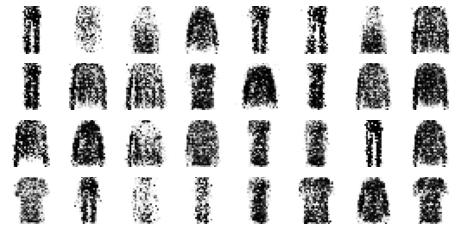

In [72]:
train_gan(gan, dataset, batch_size, codings_size, n_epochs=1)

Epoch 1/20


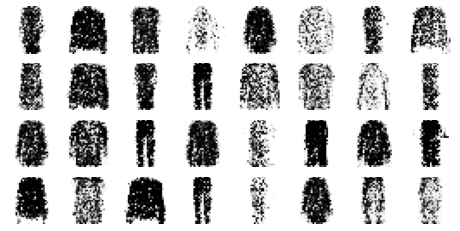

Epoch 2/20


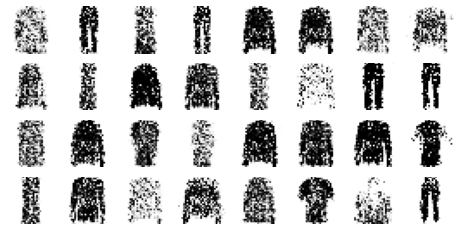

Epoch 3/20


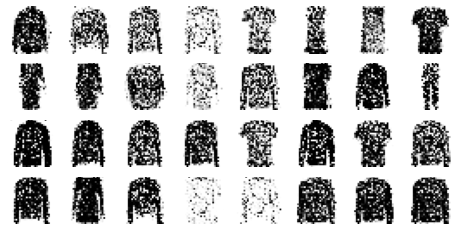

Epoch 4/20


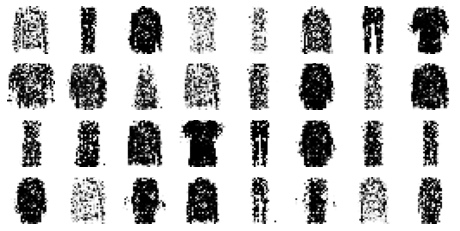

Epoch 5/20


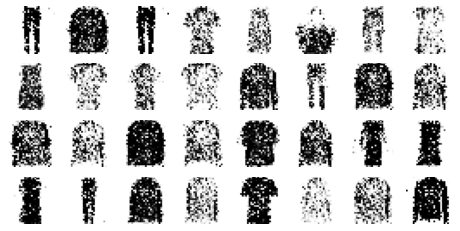

Epoch 6/20


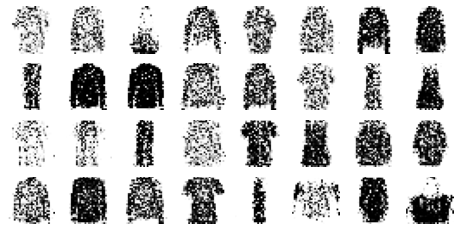

Epoch 7/20


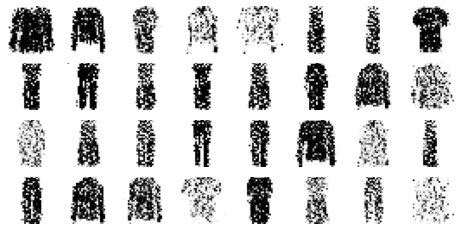

Epoch 8/20


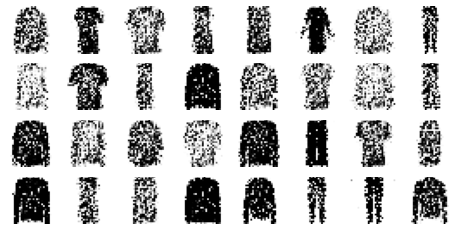

Epoch 9/20


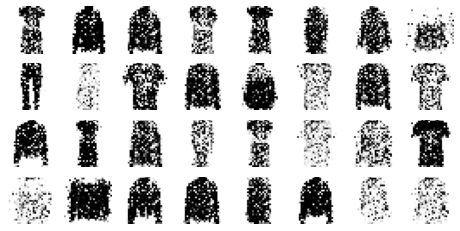

Epoch 10/20


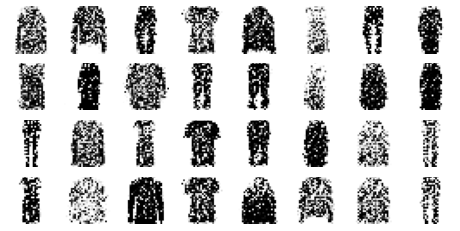

Epoch 11/20


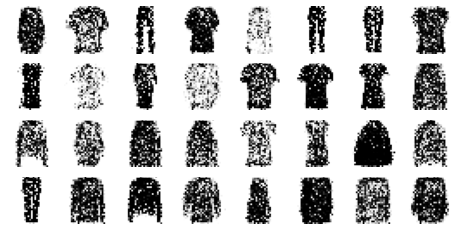

Epoch 12/20


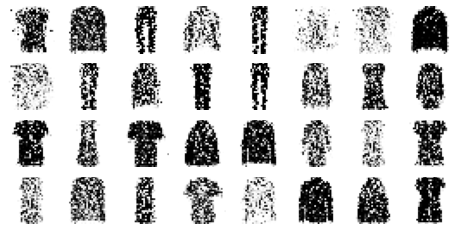

Epoch 13/20


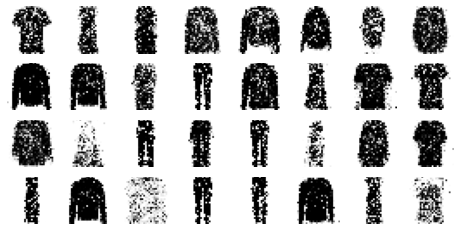

Epoch 14/20


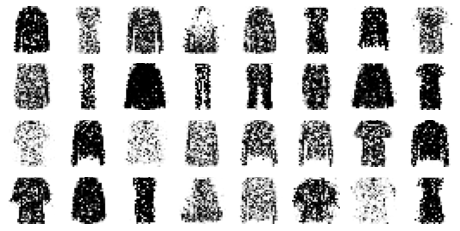

Epoch 15/20


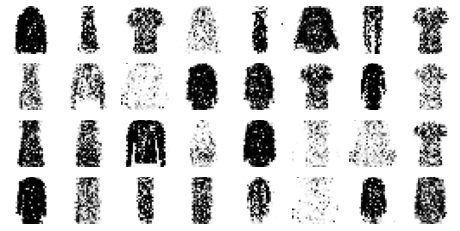

Epoch 16/20


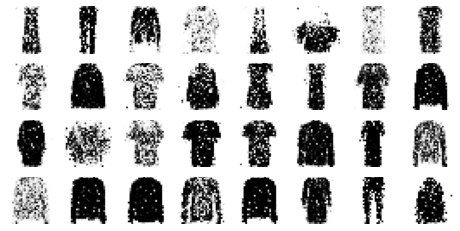

Epoch 17/20


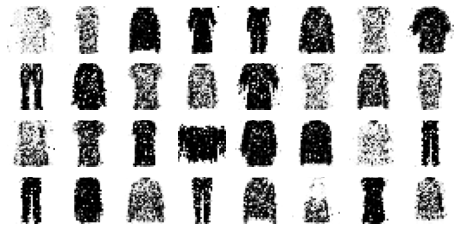

Epoch 18/20


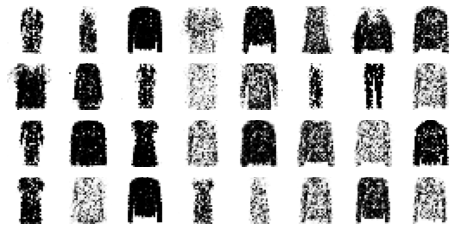

Epoch 19/20


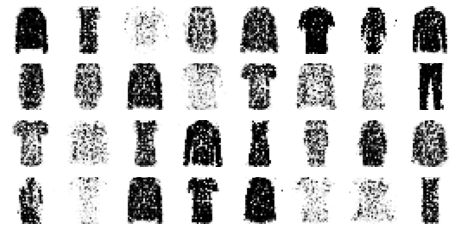

Epoch 20/20


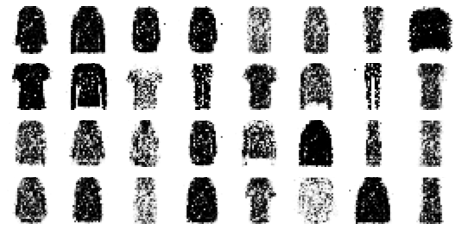

In [50]:
# Ahora lo dejamos corriendo un rato (largo)
train_gan(gan, dataset, batch_size, codings_size, n_epochs=20)

## DCGAN

In [73]:
# Codigo de Géron (https://github.com/ageron/handson-ml2)
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 100

generator = keras.models.Sequential([
    keras.layers.Dense(7 * 7 * 128, input_shape=[codings_size]),
    keras.layers.Reshape([7, 7, 128]),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="SAME",
                                 activation="selu"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2DTranspose(1, kernel_size=5, strides=2, padding="SAME",
                                 activation="tanh"),
])
discriminator = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2),
                        input_shape=[28, 28, 1]),
    keras.layers.Dropout(0.4),
    keras.layers.Conv2D(128, kernel_size=5, strides=2, padding="SAME",
                        activation=keras.layers.LeakyReLU(0.2)),
    keras.layers.Dropout(0.4),
    keras.layers.Flatten(),
    keras.layers.Dense(1, activation="sigmoid")
])
gan = keras.models.Sequential([generator, discriminator])

In [74]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [75]:
X_train_dcgan = X_train.reshape(-1, 28, 28, 1) * 2. - 1. # reshape and rescale

In [76]:
batch_size = 32
dataset = tf.data.Dataset.from_tensor_slices(X_train_dcgan)
dataset = dataset.shuffle(1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

Epoch 1/50


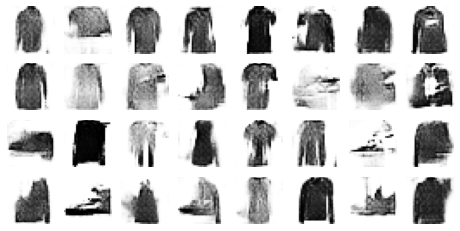

Epoch 2/50


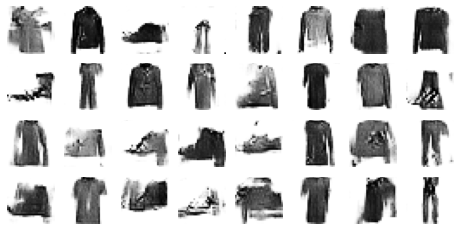

Epoch 3/50


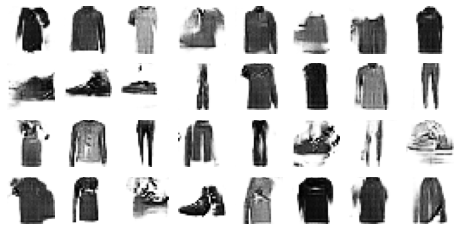

Epoch 4/50


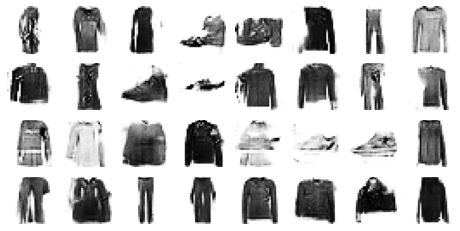

Epoch 5/50


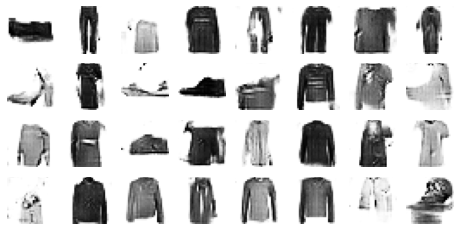

Epoch 6/50


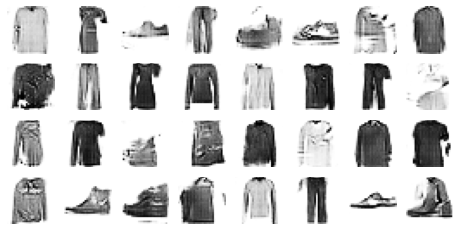

Epoch 7/50


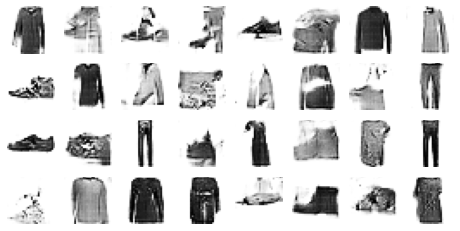

Epoch 8/50


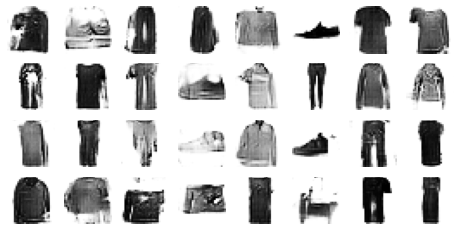

Epoch 9/50


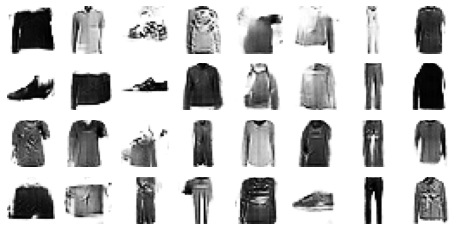

Epoch 10/50


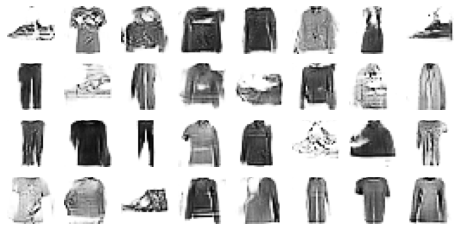

Epoch 11/50


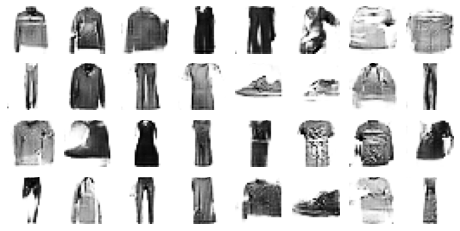

Epoch 12/50


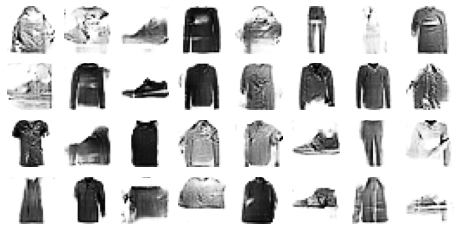

Epoch 13/50


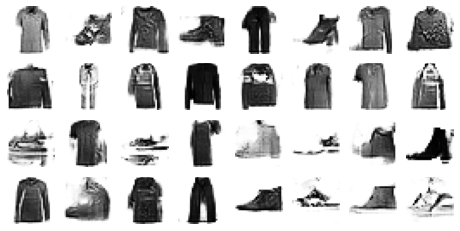

Epoch 14/50


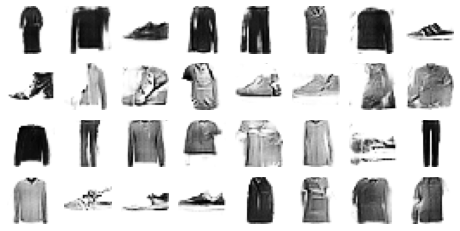

Epoch 15/50


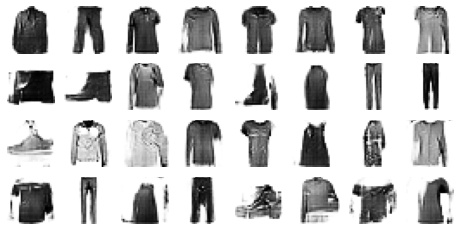

Epoch 16/50


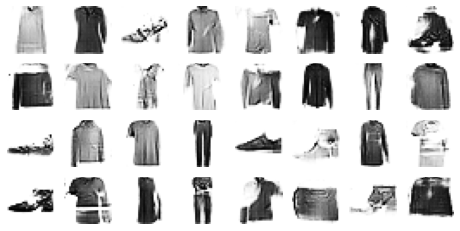

Epoch 17/50


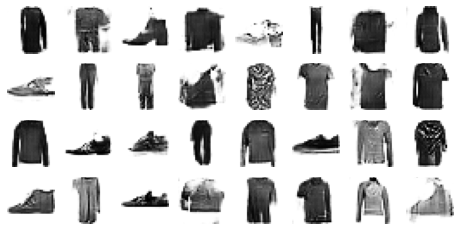

Epoch 18/50


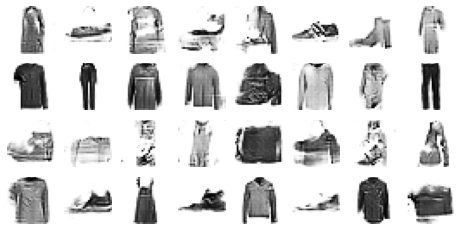

Epoch 19/50


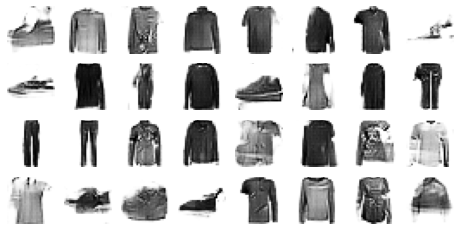

Epoch 20/50


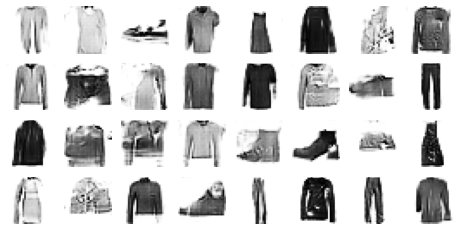

Epoch 21/50


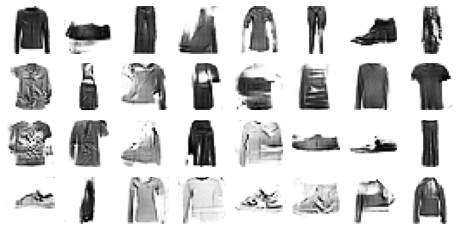

Epoch 22/50


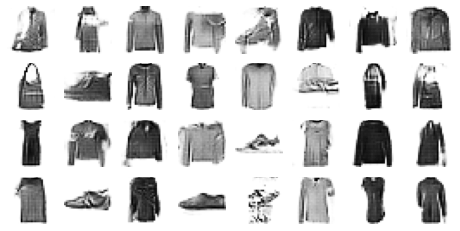

Epoch 23/50


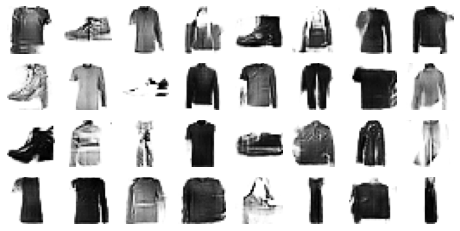

Epoch 24/50


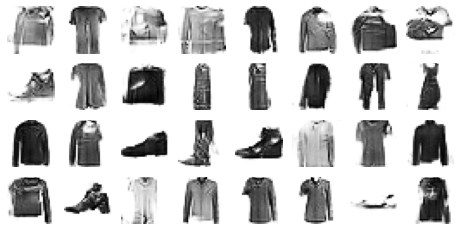

Epoch 25/50


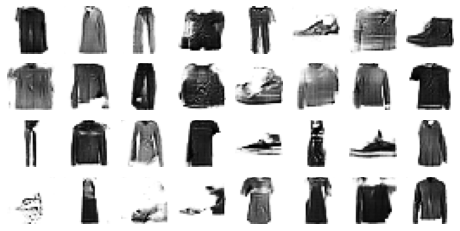

Epoch 26/50


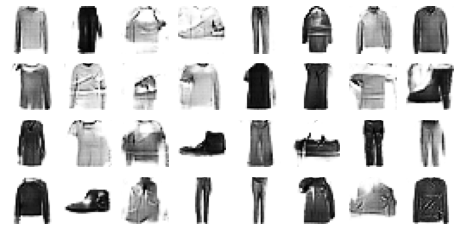

Epoch 27/50


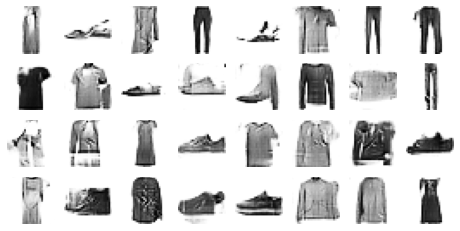

Epoch 28/50


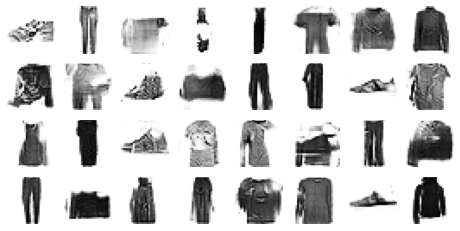

Epoch 29/50


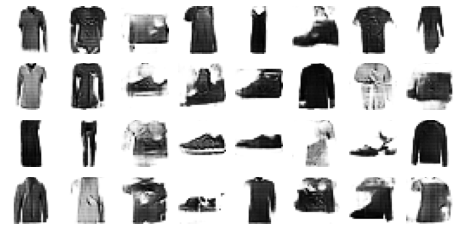

Epoch 30/50


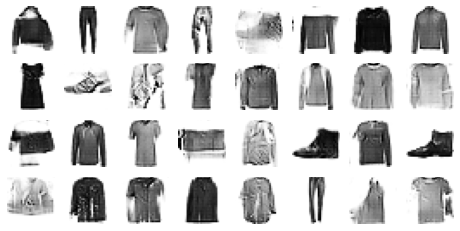

Epoch 31/50


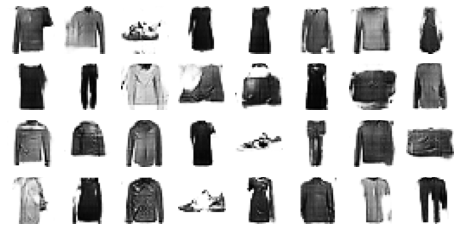

Epoch 32/50


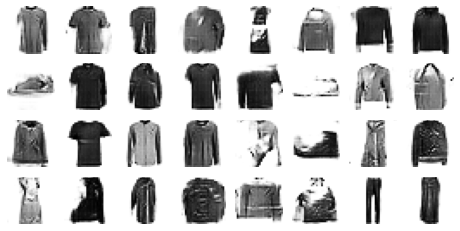

Epoch 33/50


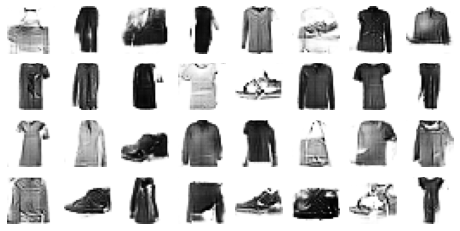

Epoch 34/50


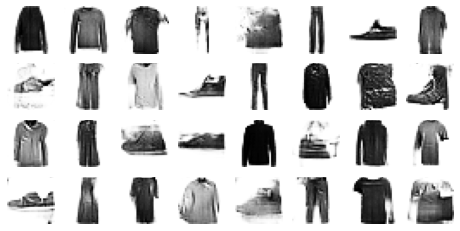

Epoch 35/50


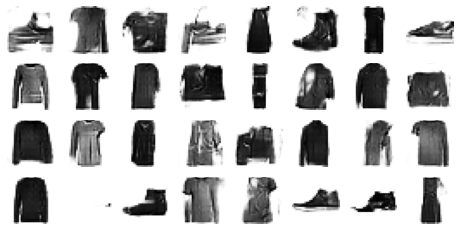

Epoch 36/50


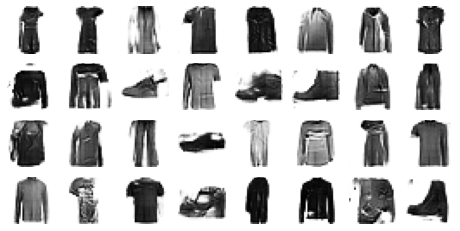

Epoch 37/50


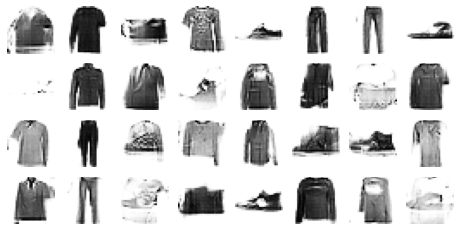

Epoch 38/50


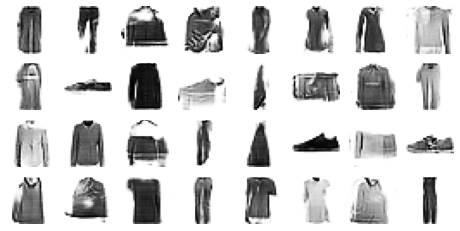

Epoch 39/50


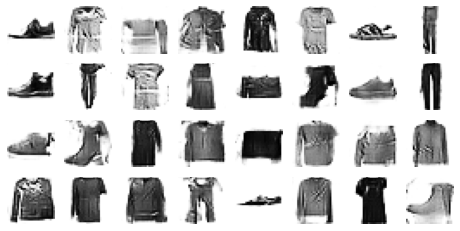

Epoch 40/50


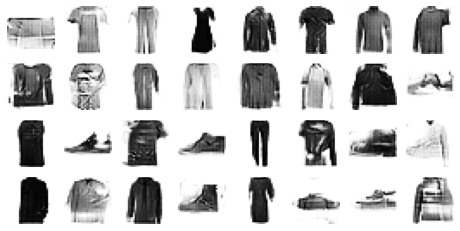

Epoch 41/50


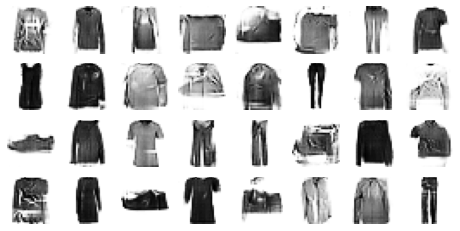

Epoch 42/50


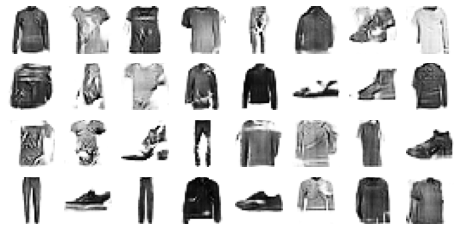

Epoch 43/50


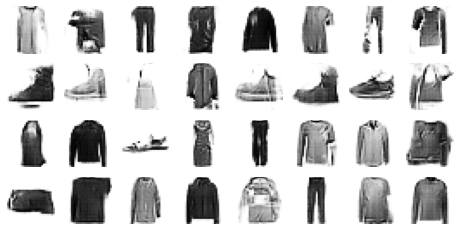

Epoch 44/50


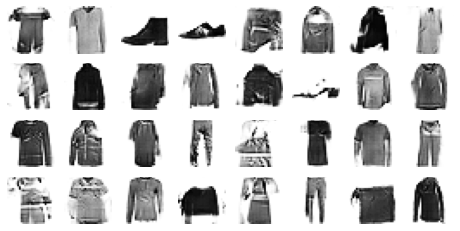

Epoch 45/50


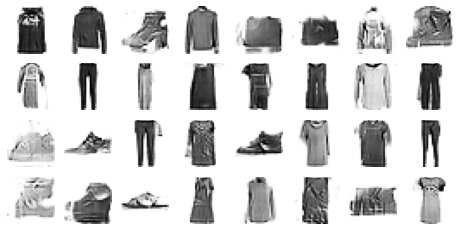

Epoch 46/50


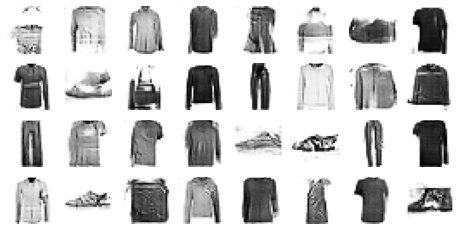

Epoch 47/50


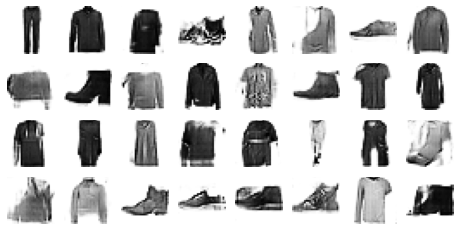

Epoch 48/50


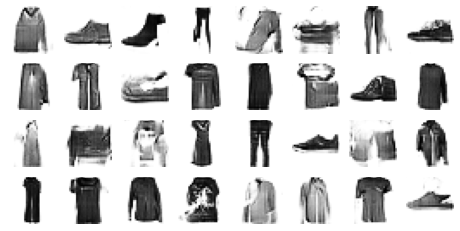

Epoch 49/50


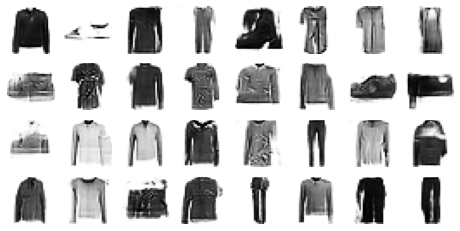

Epoch 50/50


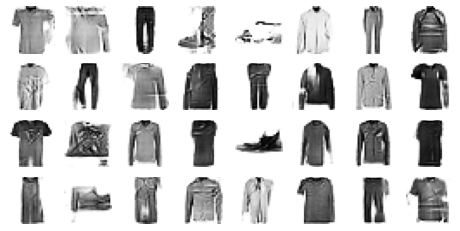

In [77]:
train_gan(gan, dataset, batch_size, codings_size)